In [1]:
import random
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np 

from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/gnn_auto')

In [2]:
from utils import load_data, prepare_data

X, y, label_map = load_data('../dataset/train/cross_subject_data_5_subjects.pickle')
class_names = list(label_map.keys())

seq_len = 100
X, y = prepare_data(X, y, seq_len, normalize=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)


X original shape: (295008, 64)
y original shape: (295008,)
Seq len: 100
X conversion shape: (2950, 64, 100)
y conversion shape: (2950,)


In [3]:
from utils import compute_adj_matrices
A = compute_adj_matrices('s')
print(A)

64
[[0.         0.07259316 0.0377163  ... 0.         0.         0.        ]
 [0.07259316 0.         0.07242256 ... 0.         0.         0.        ]
 [0.0377163  0.07242256 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.10730997 0.10929675]
 [0.         0.         0.         ... 0.10730997 0.         0.09523205]
 [0.         0.         0.         ... 0.10929675 0.09523205 0.        ]]


In [4]:
from utils import get_dataloaders

batch_size = 32
dataloaders, dataset_sizes = get_dataloaders(X_train, y_train, X_test, y_test, batch_size)

In [5]:
in_features = seq_len
hidden_size_1 = 1024
hidden_size_2 = 2048
hidden_size_3 = 1024
hidden_size_4 = 4
num_classes = 4
n_channels = 64


from layers_batchwise_2 import GraphConvolution

class GCN(nn.Module):
    def __init__(self, in_features, n_nodes, num_classes):
        super(GCN, self).__init__()
        self.gc1 = GraphConvolution(in_features, hidden_size_1, batch_size, n_channels)
        self.gc2 = GraphConvolution(hidden_size_1, hidden_size_2, batch_size, n_channels)
        self.gc3 = GraphConvolution(hidden_size_2, hidden_size_3, batch_size, n_channels)
        # self.gc4 = GraphConvolution(hidden_size_3, hidden_size_4, batch_size, n_channels)
        # self.flatten = nn.Flatten()
        # self.linear = nn.Linear(hidden_size_4*n_channels, num_classes)
        self.node_embeddings = nn.Parameter(torch.randn(n_nodes, n_nodes), requires_grad=True)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(hidden_size_3*n_channels, num_classes)

        self.node_embeddings = nn.Parameter(torch.randn(n_nodes, n_nodes), requires_grad=True)
    def forward(self, x):
        # print(x.shape)
        A = F.softmax(F.relu(torch.mm(self.node_embeddings, self.node_embeddings.transpose(0, 1))), dim=1)
        A = A + torch.eye(A.shape[0]).to(device)
        out = F.relu(self.gc1(x, self.node_embeddings))
        # print(out.shape)
        out = F.relu(self.gc2(out, self.node_embeddings))
        # print(out.shape)
        out = F.relu(self.gc3(out, self.node_embeddings))
        # print(out.shape)
        # out = F.relu(self.gc4(out, A))
        # print(out.shape)
        out = self.flatten(out)
        # print(out.shape)
        out = self.linear(out)
        # print(out.shape)
        return out


model = GCN(in_features=in_features, n_nodes=n_channels, num_classes=num_classes).to(device)

from utils import init_model_params
model = init_model_params(model)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


# writer.add_graph(model, X_train[:batch_size])

In [6]:
from utils import train_model

num_epochs = 100
train_model(dataloaders, dataset_sizes, model, criterion, optimizer, num_epochs, writer)

Epoch 0/99
----------
train Loss: 11.7159 Acc: 0.2581
val Loss: 1.5198 Acc: 0.2525

Epoch 1/99
----------
train Loss: 1.3816 Acc: 0.2996
val Loss: 1.3560 Acc: 0.2678

Epoch 2/99
----------
train Loss: 1.2915 Acc: 0.3627
val Loss: 1.4644 Acc: 0.2593

Epoch 3/99
----------
train Loss: 1.2650 Acc: 0.3970
val Loss: 1.4604 Acc: 0.2729

Epoch 4/99
----------
train Loss: 1.2295 Acc: 0.4301
val Loss: 1.4779 Acc: 0.2949

Epoch 5/99
----------
train Loss: 1.1924 Acc: 0.4445
val Loss: 1.6058 Acc: 0.2881

Epoch 6/99
----------
train Loss: 1.1067 Acc: 0.4970
val Loss: 1.5365 Acc: 0.2712

Epoch 7/99
----------
train Loss: 0.9984 Acc: 0.5445
val Loss: 1.9520 Acc: 0.2831

Epoch 8/99
----------
train Loss: 1.0141 Acc: 0.5428
val Loss: 1.6986 Acc: 0.2797

Epoch 9/99
----------
train Loss: 0.9358 Acc: 0.5903
val Loss: 1.9373 Acc: 0.2847

Epoch 10/99
----------
train Loss: 0.9641 Acc: 0.5924
val Loss: 1.9830 Acc: 0.3017

Epoch 11/99
----------
train Loss: 0.9091 Acc: 0.6013
val Loss: 2.1277 Acc: 0.2525

E

GCN(
  (gc1): GraphConvolution (100 -> 1024)
  (gc2): GraphConvolution (1024 -> 2048)
  (gc3): GraphConvolution (2048 -> 1024)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=65536, out_features=4, bias=True)
)

In [7]:
from utils import model_predict

y_preds, y_test = model_predict(model, test_loader=dataloaders['val'])

In [8]:
from utils import print_classification_report

cr, cm = print_classification_report(y_test, y_preds, num_classes, writer)

              precision    recall  f1-score   support

           0       0.32      0.37      0.34       142
           1       0.35      0.52      0.41       147
           2       0.31      0.20      0.24       149
           3       0.35      0.24      0.28       138

    accuracy                           0.33       576
   macro avg       0.33      0.33      0.32       576
weighted avg       0.33      0.33      0.32       576

[[52 56 18 16]
 [37 76 17 17]
 [44 47 30 28]
 [32 41 32 33]]
AUROC ovo: 0.5539332039655747
AUROC ovr: 0.5539332039655747


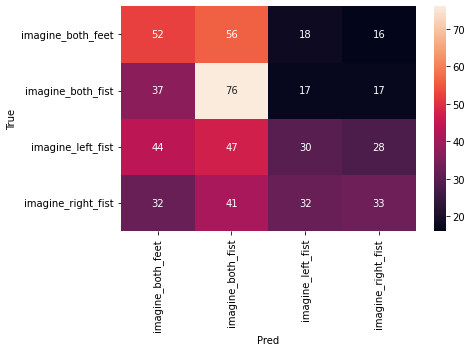

In [9]:
from utils import plot_cm

plot_cm(cm, class_names)

In [10]:
print('Number of trainable parameters')
sum(p.numel() for p in model.parameters() if p.requires_grad)

Number of trainable parameters


4567044

In [41]:
A = torch.mm(model.node_embeddings, model.node_embeddings.transpose(0, 1))
A = A.cpu().detach().numpy()

<AxesSubplot:>

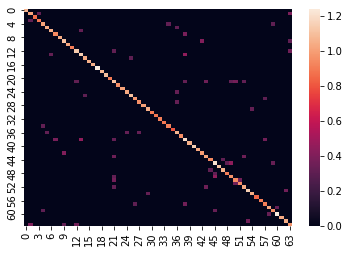

In [45]:


import seaborn as sns
threshold = 0.3
A_thresh = np.where(A > threshold, A, 0)
sns.heatmap(A_thresh)


In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

A = scaler.fit_transform(A)